# Guide on how to use the backtester

In [43]:
# Ensure the project root is in PATH.
import sys
sys.path.append("..")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader

In [44]:
from datamodel import OrderDepth, UserId, TradingState, Order, ConversionObservation, Observation

import numpy as np


CROISSANTS = "CROISSANTS"
DJEMBES = "DJEMBES"
JAMS = "JAMS"
KELP = "KELP"
PICNIC_BASKET1 = "PICNIC_BASKET1"
PICNIC_BASKET2 = "PICNIC_BASKET2"
RAINFOREST_RESIN = "RAINFOREST_RESIN"
SQUID_INK = "SQUID_INK"
VOLCANIC_ROCK = "VOLCANIC_ROCK"
VOLCANIC_ROCK_VOUCHER_10000 = "VOLCANIC_ROCK_VOUCHER_10000"
VOLCANIC_ROCK_VOUCHER_10250 = "VOLCANIC_ROCK_VOUCHER_10250"
VOLCANIC_ROCK_VOUCHER_10500 = "VOLCANIC_ROCK_VOUCHER_10500"
VOLCANIC_ROCK_VOUCHER_9500 = "VOLCANIC_ROCK_VOUCHER_9500"
VOLCANIC_ROCK_VOUCHER_9750 = "VOLCANIC_ROCK_VOUCHER_9750"
MAGNIFICENT_MACARONS = "MAGNIFICENT_MACARONS"

CAMILLA = "Camilla"
PABLO = "Pablo"
SUBMISSION = "SUBMISSION"


class OliviaSquink:
    def __init__(self):
        # CONSTANT
        self.position_limit = {SQUID_INK: 50}

        # RUNTIME
        self.last_buysignal_timestamp = -9999999
        self.last_sellsignal_timestamp = -9999999
        self.last_olivia_buyprice = -1
        self.last_olivia_sellprice = -1

        # CONFIG
        self.spread_tol = {SQUID_INK: 5} #doesnt matter
        self.signal_timeout = 2500
        pass

    def _get_mid_price(self, state: TradingState, product: str) -> float:
        buy_orders = state.order_depths[product].buy_orders
        sell_orders = state.order_depths[product].sell_orders

        return (max(buy_orders) + max(sell_orders)) / 2

    def _execute_buy(self, state: TradingState, product: str, desired_pos: int):
        orders = []
        midprice = self._get_mid_price(state, product)
        position = state.position.get(product, 0)

        for price, qty in sorted(state.order_depths[product].sell_orders.items()):
            qty_executed = min(abs(qty), desired_pos - position)

            if qty_executed > 0 and price <= midprice + self.spread_tol[product]:
                orders.append(Order(product, price, qty_executed))
                position += qty_executed

        # limit order - this is to reduce spread cost. but we lose so little in spread that this doesn't matter
        # it just helps us reach our desired position faster though. not worth the time tuning this thingy.
        qty_remaining = desired_pos - position
        if qty_remaining != 0:
            orders.append(Order(product, int(np.floor(midprice)), qty_remaining))

        return orders

    def _execute_sell(self, state: TradingState, product: str, desired_pos: int):
        orders = []
        midprice = self._get_mid_price(state, product)
        position = state.position.get(product, 0)

        for price, qty in sorted(state.order_depths[product].buy_orders.items(), reverse=True):
            qty_executed = min(qty, abs(desired_pos - position))

            if qty_executed > 0 and price >= midprice - self.spread_tol[product]:
                orders.append(Order(product, price, -qty_executed))
                position -= qty_executed

        # limit order
        qty_remaining = abs(desired_pos - position)
        if qty_remaining != 0:
            orders.append(Order(product, int(np.ceil(midprice)), -qty_remaining))

        return orders

    def run(self, state: TradingState):
        result = {}
        if SQUID_INK in state.order_depths:
            market_trades = state.market_trades.get(SQUID_INK, [])

            olivia_buy_vol = 0
            olivia_sell_vol = 0
            for trade in market_trades:
                if trade.buyer == "Olivia" and trade.seller != "Olivia":
                    olivia_buy_vol += trade.quantity
                elif trade.seller == "Olivia" and trade.buyer != "Olivia":
                    olivia_sell_vol += trade.quantity

            if olivia_buy_vol > olivia_sell_vol:
                self.last_buysignal_timestamp = state.timestamp
                self.last_olivia_buyprice = trade.price
            elif olivia_buy_vol < olivia_sell_vol:
                self.last_sellsignal_timestamp = state.timestamp
                self.last_olivia_sellprice = trade.price

            time_since_last_buysignal = state.timestamp - self.last_buysignal_timestamp
            time_since_last_sellsignal = state.timestamp - self.last_sellsignal_timestamp

            if time_since_last_buysignal < time_since_last_sellsignal and time_since_last_buysignal < self.signal_timeout:
                # limit long
                result[SQUID_INK] = self._execute_buy(state, SQUID_INK, self.position_limit[SQUID_INK])

            elif time_since_last_sellsignal < time_since_last_buysignal and time_since_last_sellsignal < self.signal_timeout:
                # limit short
                result[SQUID_INK] = self._execute_sell(state, SQUID_INK, -self.position_limit[SQUID_INK])

        return result, 0, ""

Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [45]:
# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


market_data_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_2.csv"), sep=";")
market_data_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_3.csv"), sep=";")
market_data_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_4.csv"), sep=";")

trades_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_2.csv"), sep=";")
trades_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_3.csv"), sep=";")
trades_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_4.csv"), sep=";")

observations_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_2.csv"), sep=",")
observations_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_3.csv"), sep=",")
observations_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_4.csv"), sep=",")

market_data_round_5_all3days = concatenate_historical_data([market_data_round_5_day_2, market_data_round_5_day_3, market_data_round_5_day_4])
trades_round_5_all3days = concatenate_historical_data([trades_round_5_day_2, trades_round_5_day_3, trades_round_5_day_4])
observations_round_5_all3days = concatenate_historical_data([observations_round_5_day_2, observations_round_5_day_3, observations_round_5_day_4])

Lets run the backtester

In [46]:
# 1. Define the listings. (optimisation - only define symbols we are trading)
listings = {
    # "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    # "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    # "JAMS": Listing(symbol="JAM", product="JAM", denomination="SEASHELLS"),
    # "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    # "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    # "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
    # "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK": Listing(symbol="VOLCANIC_ROCK", product="VOLCANIC_ROCK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10000": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10000", product="VOLCANIC_ROCK_VOUCHER_10000", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10250": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10250", product="VOLCANIC_ROCK_VOUCHER_10250", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10500", product="VOLCANIC_ROCK_VOUCHER_10500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9500", product="VOLCANIC_ROCK_VOUCHER_9500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9750": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9750", product="VOLCANIC_ROCK_VOUCHER_9750", denomination="SEASHELLS"),
    # "MAGNIFICENT_MACARONS": Listing(symbol="MAGNIFICENT_MACARONS", product="MAGNIFICENT_MACARONS", denomination="SEASHELLS"),
}

# 2. Define the position limits. (optimisation - only define symbols we are trading)
position_limit = {
    # "CROISSANTS": 250,
    # "DJEMBES": 60,
    # "JAMS": 350,
    # "KELP": 50,
    # "PICNIC_BASKET1": 60,
    # "PICNIC_BASKET2": 100,
    # "RAINFOREST_RESIN": 50,
    "SQUID_INK": 50,
    # "VOLCANIC_ROCK": 400,
    # "VOLCANIC_ROCK_VOUCHER_10000": 200,
    # "VOLCANIC_ROCK_VOUCHER_10250": 200,
    # "VOLCANIC_ROCK_VOUCHER_10500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9750": 200,
    # "MAGNIFICENT_MACARONS": 75,
}


# 4. Market data and trade history files. (look at the previous cell)

# 5. Instantiate Trader object

trader = OliviaSquink()

# 6. Instantiate Backtester object
bt = Backtester(trader, listings, position_limit, market_data_round_5_day_4, trades_round_5_day_4, observations_round_5_day_4)
bt.run()
bt.pnl()

{'spreadcrossing': {'SQUID_INK': 7098.0, 'total': 7098.0},
 'midpoint': {'SQUID_INK': 7426.5, 'total': 7426.5}}

Available metrics: ['timestamp', 'spreadcrossing_pnl', 'spreadcrossing_final_pnl', 'spreadcrossing_sharpe', 'spreadcrossing_pnl_bps', 'midpoint_pnl', 'midpoint_final_pnl', 'midpoint_sharpe', 'midpoint_pnl_bps', 'position']
Midpoint sharpe: 0.15947417512547576
Spreadcrossing sharpe: 0.15237830663757848


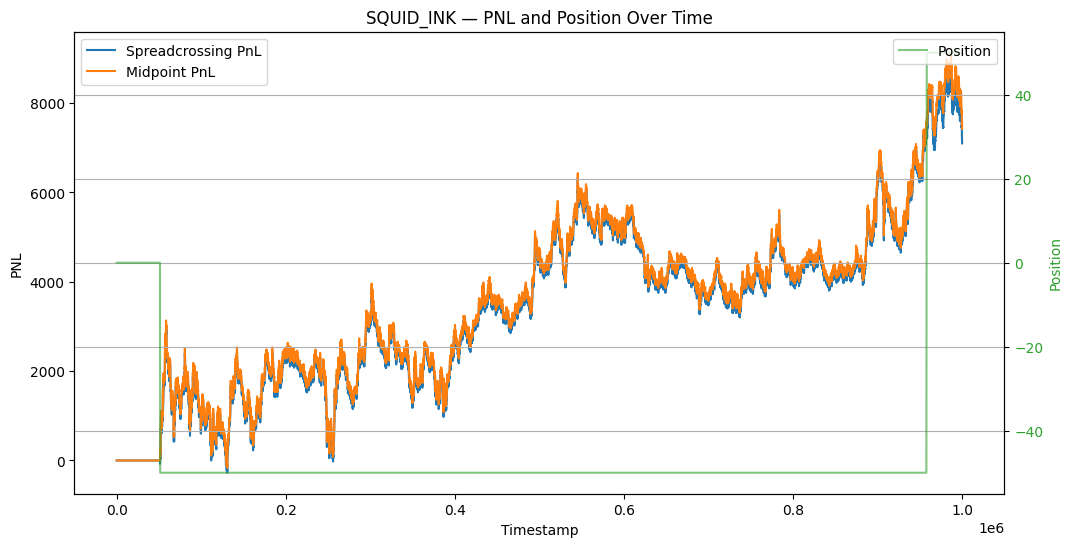

In [47]:
import matplotlib.pyplot as plt

product = SQUID_INK
metrics = bt.calculate_metrics(product)

print(f"Available metrics: {list(metrics.keys())}")

print(f"Midpoint sharpe: {metrics['midpoint_sharpe']}")
print(f"Spreadcrossing sharpe: {metrics['spreadcrossing_sharpe']}")
fig, ax1 = plt.subplots(figsize=(12, 6))

# First y-axis: PnL
ax1.plot(metrics['timestamp'], metrics['spreadcrossing_pnl'], label='Spreadcrossing PnL', color='tab:blue')
ax1.plot(metrics['timestamp'], metrics['midpoint_pnl'], label='Midpoint PnL', color='tab:orange')
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("PNL", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Second y-axis: Position
ax2 = ax1.twinx()
ax2.plot(metrics['timestamp'], metrics['position'], label='Position', color='tab:green', alpha=0.6)
ax2.set_ylabel("Position", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title(f"{product} — PNL and Position Over Time")
plt.grid(True)
plt.show()




Looks quite promising.  

self.spread_tol = 5  # how much we are willing to cross the spread buy to execute  
self.signal_timeout = 2000  # time until we stop moving directionally on a previous signal  
self.signal_volume_threshold = 1  # the threshold of difference in camilla's buy, sell volume to take it as a signal  

Lets try gridsearch to optimise  

In [48]:
# import itertools
# import pandas as pd
# from tqdm import tqdm
# from joblib import Parallel, delayed

# # 1) Define your parameter grid
# param_grid = {
#     "spread_tol":             list(range(0, 11)),            # 0…10
#     "signal_timeout":         list(range(100, 1501, 100)),   # 100,200,…,1500
#     "signal_volume_threshold": list(range(0, 9)),            # 0…8
# }

# # 2) Make every combination
# combos = list(itertools.product(
#     param_grid["spread_tol"],
#     param_grid["signal_timeout"],
#     param_grid["signal_volume_threshold"],
# ))

# # 3) The function to run one backtest
# def eval_params(params):
#     spread_tol, timeout, vol_th = params
    
#     # re‑instantiate a fresh trader & set its params
#     trader = CamillaPabloTrader()
#     trader.spread_tol              = spread_tol
#     trader.signal_timeout          = timeout
#     trader.signal_volume_threshold = vol_th
    
#     # run the backtest
#     bt = Backtester(
#         trader,
#         listings,
#         position_limit,
#         market_data_round_5_all3days,
#         trades_round_5_all3days,
#         observations_round_5_all3days
#     )
#     bt.run()
#     pnl = bt.pnl()
    
#     return {
#         "spread_tol": spread_tol,
#         "signal_timeout": timeout,
#         "signal_volume_threshold": vol_th,
#         "spreadcrossing_pnl": pnl['spreadcrossing'][PICNIC_BASKET2],
#         "midpoint_pnl": pnl['midpoint'][PICNIC_BASKET2]
#     }

# # 4) Kick off the grid‑search in parallel
# results = Parallel(n_jobs=-1)(
#     delayed(eval_params)(params)
#     for params in tqdm(combos, desc="Grid searching", total=len(combos))
# )

# # 5) Collect into a DataFrame & sort by PnL
# df = pd.DataFrame(results)
# df = df.sort_values("midpoint_pnl", ascending=False).reset_index(drop=True)

# # 6) Inspect the top configs
# print(df.head(10))


In [49]:
df = df.sort_values("midpoint_pnl", ascending=False).reset_index(drop=True)

df

NameError: name 'df' is not defined

In [ ]:
th = trades_round_5_day_4.copy()




th = th[th['symbol'] == PICNIC_BASKET2]

np.sum(th['quantity'])


def calc_spread_stats(market_data: pd.DataFrame, product: str):
    md = market_data.copy()
    md = md[md['product'] == product]

    spread = md['ask_price_1'] - md['bid_price_1']

    return np.mean(spread), np.std(spread)



print(f"{CROISSANTS}: {calc_spread_stats(market_data_round_5_day_4, CROISSANTS)}")
print(f"{JAMS}: {calc_spread_stats(market_data_round_5_day_4, JAMS)}")
print(f"{PICNIC_BASKET2}: {calc_spread_stats(market_data_round_5_day_4, PICNIC_BASKET2)}")

CROISSANTS: (1.2093, 0.40680893549675134)
JAMS: (1.615, 0.4865953144040744)
PICNIC_BASKET2: (5.2088, 1.0970882188775886)


In [ ]:
th = trades_round_5_all3days.copy()

party = "Peter"
th = th[(th['buyer'] == party) ^ (th['seller'] == party)]

# np.unique(th['quantity'])
d = th['timestamp'].diff().dropna()
np.mean(d), np.std(d)


# md = market_data_round_5_all3days.copy()
# md = md[md['product'] == KELP]


# spread = md['ask_price_1'] - md['bid_price_1']


(7323.471882640587, 6937.815773104108)